# Model Description
The two-stage stochastic optimization model maximizes the expected profit of a PV-battery system trading in day-ahead (DA) and intraday (ID) electricity markets while managing risk via Conditional Value at Risk (CVaR). **Uncertainties** arise from stochastic PV generation ($\mathbf{P_{t,\omega}^{PV}}$) and ID market prices ($\mathbf{\lambda_{t,\omega}^{ID}}$), which vary across scenarios $\mathbf{\omega}$. These uncertainties are modeled using multiple scenarios with associated probabilities ($\mathbf{\pi_{\omega}}$), capturing variability in solar output and market conditions. **In the first stage**, scenario-independent decisions ($\mathbf{P_{t}^{DA}}$, $\mathbf{P_{t}^{ch}}$, $\mathbf{P_{t}^{dis}}$) are made before uncertainties are realized, based on expected PV generation and DA prices ($\mathbf{\lambda_{t}^{DA}}$). **In the second stage**, scenario-dependent adjustments ($\mathbf{P_{t,\omega}^{ID}}$, $\mathbf{\delta P_{t,\omega}^{ch}}$, $\mathbf{\delta P_{t,\omega}^{dis}}$) are made after observing actual PV output and ID prices for each scenario, allowing the system to correct DA bids and manage imbalances. The objective balances expected profit (DA/ID revenues minus imbalance penalties) with CVaR to limit losses in worst-case scenarios. Constraints ensure power balance, battery dynamics (with charging/discharging efficiencies), terminal state of charge, PV spillage limits, and bounded market trades to prevent unbounded solutions. The model supports risk-averse decision-making under uncertainty in renewable generation and market prices.

#Evaluations:

The model is a robust two-stage stochastic program for battery trading, with well-defined coupling constraints and risk management via CVaR. Improvements like scenario reduction, scenario-dependent battery modes, degradation costs, and ramping constraints enhance its accuracy and realism. For practicality, focus on solver performance, data integration, sensitivity analysis, and market-specific tailoring. These changes make the model a powerful tool for traders, balancing computational feasibility with real-world applicability. If you’re targeting a specific market or have computational constraints, I can suggest more tailored enhancements—let me know! :)

# Two-Stage Stochastic Battery Optimization Model

### 1. Power Balance
$$
\forall t, \omega:\quad
\color{blue}{P^{DA}_t} + \color{blue}{P^{ID}_{t,\omega}} + \color{blue}{\Delta^-_{t,\omega}} - \color{blue}{\Delta^+_{t,\omega}}
= PV_{t,\omega} + (\color{green}{P^{dis}_t} + \color{green}{\delta P^{dis}_{t,\omega}}) - (\color{green}{P^{ch}_t} + \color{green}{\delta P^{ch}_{t,\omega}})
$$

### 2. Battery SOC Dynamics
$$
\forall t=1, \omega:\quad
\color{blue}{SOC_{t,\omega}} = SOC_0 + \eta_{ch} \cdot (\color{green}{P^{ch}_t} + \color{green}{\delta P^{ch}_{t,\omega}}) - \frac{1}{\eta_{dis}} \cdot (\color{green}{P^{dis}_t} + \color{green}{\delta P^{dis}_{t,\omega}})
$$
$$
\forall t>1, \omega:\quad
\color{blue}{SOC_{t,\omega}} = \color{blue}{SOC_{t-1,\omega}} + \eta_{ch} \cdot (\color{green}{P^{ch}_t} + \color{green}{\delta P^{ch}_{t,\omega}}) - \frac{1}{\eta_{dis}} \cdot (\color{green}{P^{dis}_t} + \color{green}{\delta P^{dis}_{t,\omega}})
$$

### 3. SOC Limits
$$
\forall t, \omega:\quad 0 \le \color{blue}{SOC_{t,\omega}} \le Cap
$$

### 4. Charging/Discharging Mode (Binary)
$$
\forall t, \omega:\quad
\color{green}{P^{ch}_t} + \color{green}{\delta P^{ch}_{t,\omega}} \le P_{\max} \cdot \color{red}{b_t}
$$
$$
\forall t, \omega:\quad
\color{green}{P^{dis}_t} + \color{green}{\delta P^{dis}_{t,\omega}} \le P_{\max} \cdot (1 - \color{red}{b_t})
$$

### 5. DA and ID Trading Limits
$$
\forall t:\quad -P_{\max}^{trade} \le \color{blue}{P^{DA}_t} \le P_{\max}^{trade}
$$
$$
\forall t, \omega:\quad -P_{\max}^{trade} \le \color{blue}{P^{ID}_{t,\omega}} \le P_{\max}^{trade}
$$

### 6. Imbalance Limits
$$
\forall t, \omega:\quad 0 \le \color{blue}{\Delta^+_{t,\omega}}, \color{blue}{\Delta^-_{t,\omega}} \le P_{\max}^{trade}
$$

### 7. CVaR Shortfall
$$
\forall \omega:\quad
\color{blue}{\eta_\omega} \ge \color{blue}{\zeta} - \sum_{t \in \mathcal{T}}
\Big[ \lambda^{DA}_t \color{blue}{P^{DA}_t} + \lambda^{ID}_{t,\omega} \color{blue}{P^{ID}_{t,\omega}} - c_{imb} (\color{blue}{\Delta^+_{t,\omega}} + \color{blue}{\Delta^-_{t,\omega}}) \Big]
$$

### 8. Variable Bounds
$$
\forall t, \omega:\quad
0 \le \color{green}{P^{ch}_t} + \color{green}{\delta P^{ch}_{t,\omega}} \le P_{\max}, \quad
0 \le \color{green}{P^{dis}_t} + \color{green}{\delta P^{dis}_{t,\omega}} \le P_{\max}
$$
$$
\forall t:\quad \color{red}{b_t} \in \{0,1\}, \quad
\forall \omega:\quad \color{blue}{\eta_\omega} \ge 0
$$

### 9. Objective Function
$$
\max \; (1-\beta)
\sum_{\omega \in \Omega} \pi_\omega
\sum_{t \in \mathcal{T}} \Big[
\lambda^{DA}_t \color{blue}{P^{DA}_t}
+ \lambda^{ID}_{t,\omega} \color{blue}{P^{ID}_{t,\omega}}
- c_{imb} (\color{blue}{\Delta^+_{t,\omega}} + \color{blue}{\Delta^-_{t,\omega}})
\Big]
+ \beta
\Bigg(
\color{blue}{\zeta}
- \frac{1}{1-\alpha}
\sum_{\omega \in \Omega} \pi_\omega \color{blue}{\eta_\omega}
\Bigg)
$$

In [ ]:
# Install Pyomo and CBC
!pip install pyomo -q
!apt-get install -y -qq coinor-cbc

In [ ]:
import numpy as np
import pandas as pd
import pyomo.environ as pe
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import matplotlib.pyplot as plt

In [ ]:
!pip install xmltodict

In [ ]:
import requests
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt

# --- Fetch Day-Ahead Prices from ENTSO-E ---
API_KEY = "yourkey"
url = "https://web-api.tp.entsoe.eu/api"

params = {
    "securityToken": API_KEY,
    "documentType": "A44",  # Day-ahead prices
    "in_Domain": "10YNL----------L",
    "out_Domain": "10YNL----------L",
    "periodStart": "202505090000",
    "periodEnd":   "202505112300"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = xmltodict.parse(response.text)
    ts = data["Publication_MarketDocument"]["TimeSeries"]
    if isinstance(ts, list):
        ts = ts[0]
    points = ts["Period"]["Point"]
    if isinstance(points, dict):
        points = [points]

    prices = [float(p["price.amount"]) for p in points]
else:
    raise Exception(f"ENTSO-E API Error: {response.status_code}")

# Map prices to Pyomo time index
lambda_DA = {t+1: prices[t] for t in range(len(prices))}
print(lambda_DA)

{1: 103.65, 2: 90.88, 3: 88.33, 4: 89.66, 5: 99.0, 6: 109.07, 7: 141.0, 8: 137.88, 9: 107.22, 10: 77.53, 11: 46.18, 12: 0.1, 13: -0.54, 14: -0.03, 15: -0.01, 16: -0.2, 17: 46.01, 18: 70.04, 19: 93.25, 20: 119.69, 21: 152.56, 22: 138.83, 23: 112.99, 24: 98.06}


In [ ]:
# Parameters
T = range(1, 25)  # Time periods (1-24)
Omega = range(1, 4)  # Scenarios (1-3)
pi_omega = {1: 0.4, 2: 0.3, 3: 0.3}  # Probabilities
alpha = 0.95  # Confidence level
beta = 0.5    # Risk aversion (0-1)
c_imb = 200   # Imbalance penalty (€/MWh)
Cap = 10      # Battery capacity (MWh)
Pmax = 5      # Max charge/discharge (MW)
eta_ch = 0.95 # Charging efficiency
eta_dis = 0.95 # Discharging efficiency
SOC0 = 5      # Initial SOC (MWh)
Pmax_trade = 10  # Max trade limit (MW, based on max PV=3 + Pmax=5)
##
np.random.seed(42)  # for reproducibility

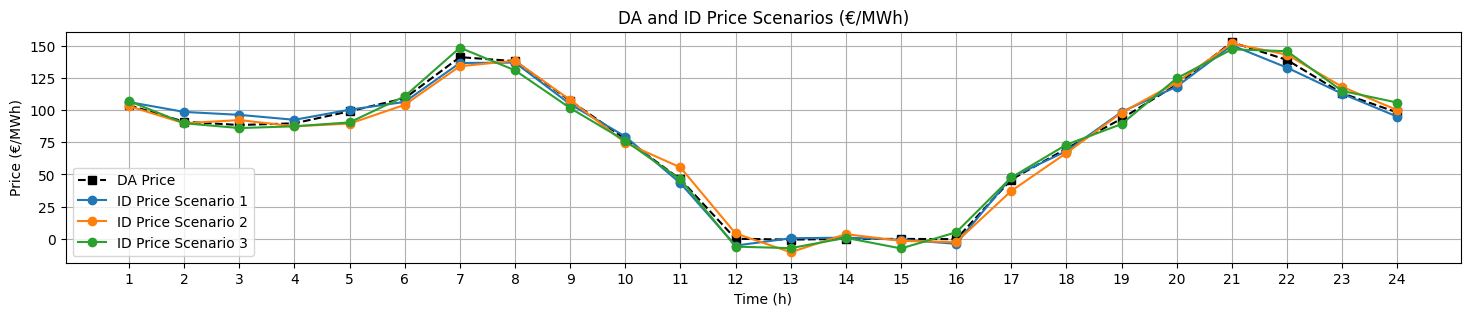

In [ ]:
# Intraday prices (€/MWh) - fluctuates around DA price
lambda_ID = {}
for t in T:
    for omega in Omega:
        fluctuation = np.random.normal(0, 5)  # ±5 €/MWh random
        lambda_ID[(t, omega)] = lambda_DA[t] + fluctuation


# --- Plot Day-Ahead and Intraday Prices ---
plt.figure(figsize=(18, 3))

# DA price is the same across scenarios
da_values = [lambda_DA[t] for t in T]
plt.plot(T, da_values, marker='s', linestyle='--', color='black', label='DA Price')

# ID prices per scenario
for omega in Omega:
    id_values = [lambda_ID[(t, omega)] for t in T]
    plt.plot(T, id_values, marker='o', label=f'ID Price Scenario {omega}')

plt.title('DA and ID Price Scenarios (€/MWh)')
plt.xlabel('Time (h)')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.legend()
plt.xticks(T)
plt.show()

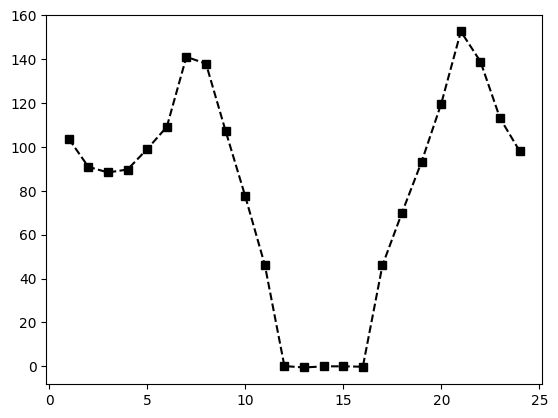

In [ ]:
# DA price is the same across scenarios
da_values = [lambda_DA[t] for t in T]
plt.plot(T, da_values, marker='s', linestyle='--', color='black', label='DA Price')

In [ ]:
pip install pvlib

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import matplotlib.pyplot as plt

# Coordinates for Amsterdam
latitude = 52.3676
longitude = 4.9041

# Fetch hourly PV data for the year 2020
data, meta = get_pvgis_hourly(
    latitude, longitude,
    start=2020, end=2020,
    raddatabase='PVGIS-SARAH3',
    components=True,
    peakpower=10,   # system size (kW or MW depending on scaling)
    loss=14,
    surface_tilt=30,
    surface_azimuth=180,
    pvcalculation=True
)

# Pick three representative days (scenarios)
days = ['2020-04-22', '2020-04-25', '2020-04-29']  # spring, summer, winter

In [ ]:
# Define sets
T = range(1, 25)  # hours of the day
Omega = range(1, 4)  # 3 scenarios
PV = {}

# Fill PV dictionary from real data
for omega, day in zip(Omega, days):
    pv_day = data.loc[day]['P'].values  # hourly PV generation
    for t in T:
        PV[(t, omega)] = max(0, pv_day[t-1])/ 1000  # ensure non-negative # convert kW → MW

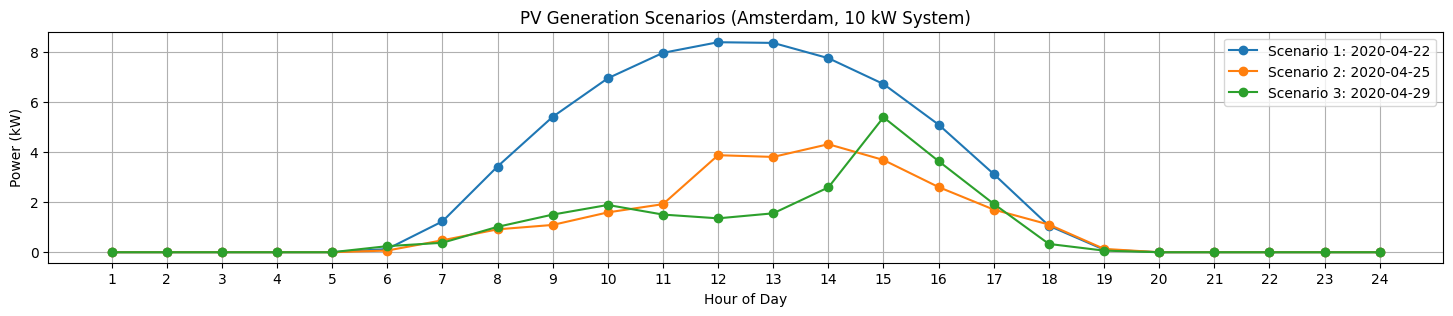

In [ ]:
plt.figure(figsize=(18, 3))
for omega, day in zip(Omega, days):
    pv_values = [PV[(t, omega)] for t in T]
    plt.plot(T, pv_values, marker='o', label=f'Scenario {omega}: {day}')
plt.title('PV Generation Scenarios (Amsterdam, 10 kW System)')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.xticks(T)
plt.show()

In [ ]:
# Model
model = pe.ConcreteModel()

# Sets
model.T = pe.Set(initialize=T, ordered=True)
model.Omega = pe.Set(initialize=Omega)

# Variables: First-stage
model.P_DA = pe.Var(model.T, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))  # DA schedule (MW)

# Battery binary: scenario-independent
model.b = pe.Var(model.T, domain=pe.Binary)  # 1=charge mode, 0=discharge mode

# Two-stage battery variables
model.P_ch_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
model.P_dis_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
model.P_ch_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))
model.P_dis_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))

# Market variables: ID trades and imbalances
model.P_ID = pe.Var(model.T, model.Omega, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))
model.delta_imb_plus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))
model.delta_imb_minus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))

# SOC
model.SOC = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Cap))

# CVaR variables
model.zeta = pe.Var(domain=pe.Reals)
model.eta = pe.Var(model.Omega, domain=pe.NonNegativeReals)

# Objective
def expected_profit_rule(m):
    exp_profit = 0
    for omega in m.Omega:
        scenario_profit = 0
        for t in m.T:
            scenario_profit += (
                lambda_DA[t] * m.P_DA[t]
                + lambda_ID[(t, omega)] * m.P_ID[t, omega]
                - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
            )
        exp_profit += pi_omega[omega] * scenario_profit
    cvar_term = m.zeta - (1 / (1 - alpha)) * sum(pi_omega[omega] * m.eta[omega] for omega in m.Omega)
    return (1 - beta) * exp_profit + beta * cvar_term
model.obj = pe.Objective(rule=expected_profit_rule, sense=pe.maximize)

# Power balance
def power_balance_rule(m, t, omega):
    return (
        m.P_DA[t] + m.P_ID[t, omega] + m.delta_imb_minus[t, omega] - m.delta_imb_plus[t, omega]
        == PV[(t, omega)] + m.P_dis_DA[t] + m.P_dis_ID[t, omega] - (m.P_ch_DA[t] + m.P_ch_ID[t, omega])
    )
model.power_balance = pe.Constraint(model.T, model.Omega, rule=power_balance_rule)

# SOC balance
def soc_balance_rule(m, t, omega):
    if t == m.T.first():
        return m.SOC[t, omega] == SOC0 + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - ((m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis)
    else:
        return m.SOC[t, omega] == m.SOC[m.T.prev(t), omega] + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - ((m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis)
model.soc_balance = pe.Constraint(model.T, model.Omega, rule=soc_balance_rule)

# Battery mode limits using scenario-independent binary
def ch_limit_rule(m, t, omega):
    return m.P_ch_DA[t] + m.P_ch_ID[t, omega] <= Pmax * m.b[t]
model.ch_limit = pe.Constraint(model.T, model.Omega, rule=ch_limit_rule)

def dis_limit_rule(m, t, omega):
    return m.P_dis_DA[t] + m.P_dis_ID[t, omega] <= Pmax * (1 - m.b[t])
model.dis_limit = pe.Constraint(model.T, model.Omega, rule=dis_limit_rule)

# CVaR shortfall
def shortfall_rule(m, omega):
    profit_omega = sum(
        lambda_DA[t] * m.P_DA[t]
        + lambda_ID[(t, omega)] * m.P_ID[t, omega]
        - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
        for t in m.T
    )
    return m.eta[omega] >= m.zeta - profit_omega
model.shortfall = pe.Constraint(model.Omega, rule=shortfall_rule)

# Solve
solver = SolverFactory('cbc')
results = solver.solve(model, tee=True)


# --- First-stage DataFrame (scenario-independent) ---
df_first_stage = pd.DataFrame({
    't': list(T),
    'P_DA': [pe.value(model.P_DA[t]) for t in T],
    'b': [pe.value(model.b[t]) for t in T],
    'P_ch_DA': [pe.value(model.P_ch_DA[t]) for t in T],
    'P_dis_DA': [pe.value(model.P_dis_DA[t]) for t in T]
})
df_first_stage = df_first_stage.set_index('t')

# --- Second-stage DataFrame (scenario-dependent) ---
df_second_stage_dict = {'t': list(T)}
for omega in Omega:
    df_second_stage_dict[f'P_ch_ID_{omega}'] = [pe.value(model.P_ch_ID[t, omega]) for t in T]
    df_second_stage_dict[f'P_dis_ID_{omega}'] = [pe.value(model.P_dis_ID[t, omega]) for t in T]
    df_second_stage_dict[f'P_ID_{omega}'] = [pe.value(model.P_ID[t, omega]) for t in T]
    df_second_stage_dict[f'delta_imb_plus_{omega}'] = [pe.value(model.delta_imb_plus[t, omega]) for t in T]
    df_second_stage_dict[f'delta_imb_minus_{omega}'] = [pe.value(model.delta_imb_minus[t, omega]) for t in T]
    df_second_stage_dict[f'SOC_{omega}'] = [pe.value(model.SOC[t, omega]) for t in T]

df_second_stage = pd.DataFrame(df_second_stage_dict)
df_second_stage = df_second_stage.set_index('t')

# --- Display ---
print("First-stage (scenario-independent) variables:")
display(df_first_stage.head(24))

print("Second-stage (scenario-dependent) variables:")
display(df_second_stage.head(24))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpfpgu6u8_.pyomo.lp -stat=1 -solve -solu /tmp/tmpfpgu6u8_.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 291 (0) rows, 529 (-3) columns and 1728 (-3) elements
Statistics for presolved model
Original problem has 24 integers (24 of which binary)
Presolved problem has 24 integers (24 of which binary)
==== 285 zero objective 102 different
==== absolute objective values 102 different
==== for integers 24 zero objective 1 different
24 variables have objective of -0
==== for integers absolute objective values 1 different
24 variables have objective of 0
===== end objective counts


Problem has 291 rows, 529 columns (244 with objective) and 1728 elements
There are 3 singletons

,P_DA,b,P_ch_DA,P_dis_DA
t,,,,
1,-5.000000,0.0,0.000000,0.0
2,-5.000000,1.0,0.000000,0.0
3,-5.000000,1.0,0.263158,0.0
4,0.000000,1.0,5.000000,0.0
5,5.000000,0.0,0.000000,0.0
6,5.066900,0.0,0.000000,0.0
7,7.515872,0.0,0.000000,4.5
8,10.000000,0.0,0.000000,4.5
9,6.090400,0.0,0.000000,0.0


Second-stage (scenario-dependent) variables:


,P_ch_ID_1,P_dis_ID_1,P_ID_1,delta_imb_plus_1,delta_imb_minus_1,SOC_1,P_ch_ID_2,P_dis_ID_2,P_ID_2,delta_imb_plus_2,delta_imb_minus_2,SOC_2,P_ch_ID_3,P_dis_ID_3,P_ID_3,delta_imb_plus_3,delta_imb_minus_3,SOC_3
t,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,5.000000,0.0,0.0,5.000000,0.000000,4.750000,9.750000,0.0,0.0,0.000000,0.000000,4.750000,9.750000,0.0,0.0,0.000000
2,0.000000,0.0,5.000000,0.0,0.0,5.000000,5.000000,0.000000,0.000000,0.0,0.0,4.750000,0.526316,0.000000,4.473684,0.0,0.0,0.500000
3,0.000000,0.0,4.736842,0.0,0.0,5.250000,0.263158,0.000000,4.473684,0.0,0.0,5.250000,4.736842,0.000000,0.000000,0.0,0.0,5.250000
4,0.000000,0.0,-5.000000,0.0,0.0,10.000000,0.000000,0.000000,-5.000000,0.0,0.0,10.000000,0.000000,0.000000,-5.000000,0.0,0.0,10.000000
5,0.000000,0.0,-5.000000,0.0,0.0,10.000000,0.000000,0.000000,-5.000000,0.0,0.0,10.000000,0.000000,0.000000,-5.000000,0.0,0.0,10.000000
6,0.000000,0.0,-4.939600,0.0,0.0,10.000000,0.000000,0.000000,-5.000000,0.0,0.0,10.000000,0.000000,0.000000,-4.824300,0.0,0.0,10.000000
7,0.000000,0.0,-1.784672,0.0,0.0,5.263158,0.000000,0.000000,-2.539372,0.0,0.0,5.263158,0.000000,0.500000,-2.137872,0.0,0.0,4.736842
8,0.000000,0.5,-1.574300,0.0,0.0,0.000000,0.000000,0.500000,-4.085600,0.0,0.0,0.000000,0.000000,0.000000,-4.485600,0.0,0.0,0.000000
9,0.000000,0.0,-0.680300,0.0,0.0,0.000000,0.000000,0.000000,-5.000000,0.0,0.0,0.000000,0.000000,0.000000,-4.586900,0.0,0.0,0.000000


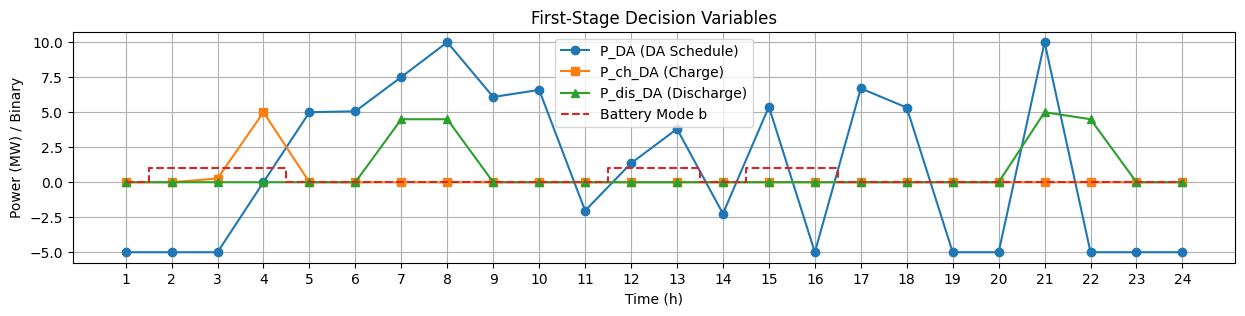

In [ ]:
plt.figure(figsize=(15,3))

# P_DA schedule
plt.plot(df_first_stage.index, df_first_stage['P_DA'], marker='o', label='P_DA (DA Schedule)')

# Battery charging/discharging
plt.plot(df_first_stage.index, df_first_stage['P_ch_DA'], marker='s', label='P_ch_DA (Charge)')
plt.plot(df_first_stage.index, df_first_stage['P_dis_DA'], marker='^', label='P_dis_DA (Discharge)')

# Battery mode (binary)
plt.step(df_first_stage.index, df_first_stage['b'], where='mid', label='Battery Mode b', linestyle='--')

plt.title('First-Stage Decision Variables')
plt.xlabel('Time (h)')
plt.ylabel('Power (MW) / Binary')
plt.grid(True)
plt.legend()
plt.xticks(df_first_stage.index)
plt.show()

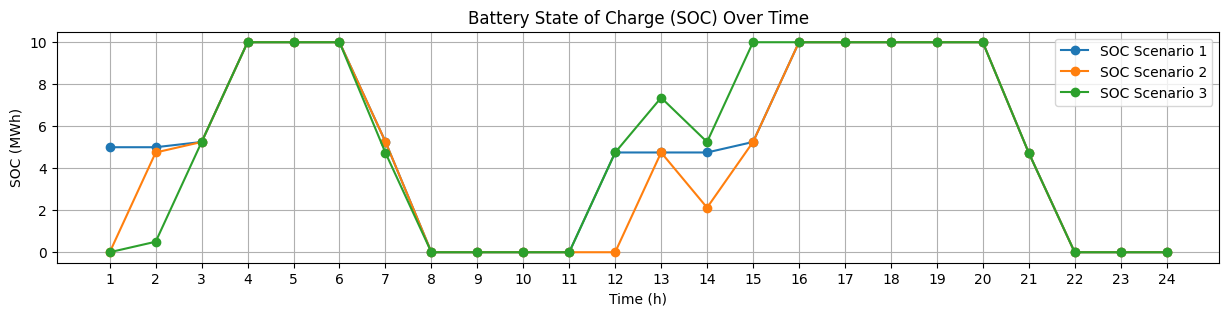

In [ ]:
plt.figure(figsize=(15,3))

for omega in Omega:
    plt.plot(df_second_stage.index, df_second_stage[f'SOC_{omega}'], marker='o', label=f'SOC Scenario {omega}')

plt.title('Battery State of Charge (SOC) Over Time')
plt.xlabel('Time (h)')
plt.ylabel('SOC (MWh)')
plt.grid(True)
plt.legend()
plt.xticks(df_second_stage.index)
plt.show()

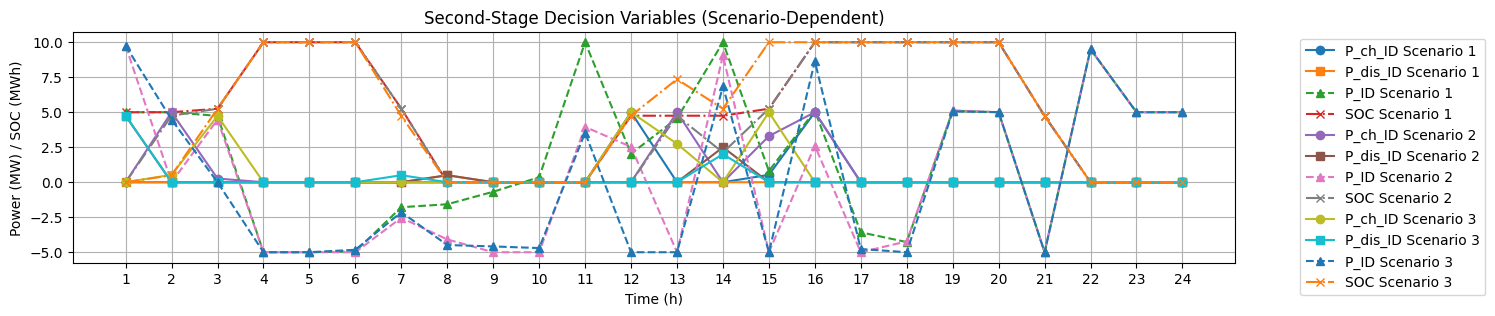

In [ ]:
plt.figure(figsize=(15,3))

# Plot for each scenario
for omega in Omega:
    plt.plot(df_second_stage.index, df_second_stage[f'P_ch_ID_{omega}'], marker='o', label=f'P_ch_ID Scenario {omega}')
    plt.plot(df_second_stage.index, df_second_stage[f'P_dis_ID_{omega}'], marker='s', label=f'P_dis_ID Scenario {omega}')
    plt.plot(df_second_stage.index, df_second_stage[f'P_ID_{omega}'], marker='^', linestyle='--', label=f'P_ID Scenario {omega}')
    plt.plot(df_second_stage.index, df_second_stage[f'SOC_{omega}'], marker='x', linestyle='-.', label=f'SOC Scenario {omega}')

plt.title('Second-Stage Decision Variables (Scenario-Dependent)')
plt.xlabel('Time (h)')
plt.ylabel('Power (MW) / SOC (MWh)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # put legend outside
plt.xticks(df_second_stage.index)
plt.show()

In [ ]:
import pyomo.environ as pe
import pandas as pd
from pyomo.opt import SolverFactory

# Define sensitivity ranges
alpha_values = [0.8, 0.9, 0.95]    # Example values
beta_values = [0.0, 0.25, 0.5, 0.75, 1.0]

results_summary = []   # to store profit results for each (alpha, beta)
all_first_stage = {}   # dict of DataFrames
all_second_stage = {}  # dict of DataFrames

# --- Sensitivity loop ---
for alpha in alpha_values:
    for beta in beta_values:

        # --- Model ---
        model = pe.ConcreteModel()

        # Sets
        model.T = pe.Set(initialize=T, ordered=True)
        model.Omega = pe.Set(initialize=Omega)

        # Variables: First-stage
        model.P_DA = pe.Var(model.T, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))

        # Battery binary
        model.b = pe.Var(model.T, domain=pe.Binary)

        # Two-stage battery variables
        model.P_ch_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_dis_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_ch_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_dis_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))

        # Market variables
        model.P_ID = pe.Var(model.T, model.Omega, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))
        model.delta_imb_plus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))
        model.delta_imb_minus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))

        # SOC
        model.SOC = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Cap))

        # CVaR variables
        model.zeta = pe.Var(domain=pe.Reals)
        model.eta = pe.Var(model.Omega, domain=pe.NonNegativeReals)

        # Objective
        def expected_profit_rule(m):
            exp_profit = 0
            for omega in m.Omega:
                scenario_profit = 0
                for t in m.T:
                    scenario_profit += (
                        lambda_DA[t] * m.P_DA[t]
                        + lambda_ID[(t, omega)] * m.P_ID[t, omega]
                        - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
                    )
                exp_profit += pi_omega[omega] * scenario_profit
            cvar_term = m.zeta - (1 / (1 - alpha)) * sum(pi_omega[omega] * m.eta[omega] for omega in m.Omega)
            return (1 - beta) * exp_profit + beta * cvar_term
        model.obj = pe.Objective(rule=expected_profit_rule, sense=pe.maximize)

        # Constraints
        def power_balance_rule(m, t, omega):
            return (
                m.P_DA[t] + m.P_ID[t, omega] + m.delta_imb_minus[t, omega] - m.delta_imb_plus[t, omega]
                == PV[(t, omega)] + m.P_dis_DA[t] + m.P_dis_ID[t, omega] - (m.P_ch_DA[t] + m.P_ch_ID[t, omega])
            )
        model.power_balance = pe.Constraint(model.T, model.Omega, rule=power_balance_rule)

        def soc_balance_rule(m, t, omega):
            if t == m.T.first():
                return m.SOC[t, omega] == SOC0 + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - (
                    (m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis
                )
            else:
                return m.SOC[t, omega] == m.SOC[m.T.prev(t), omega] + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - (
                    (m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis
                )
        model.soc_balance = pe.Constraint(model.T, model.Omega, rule=soc_balance_rule)

        def ch_limit_rule(m, t, omega):
            return m.P_ch_DA[t] + m.P_ch_ID[t, omega] <= Pmax * m.b[t]
        model.ch_limit = pe.Constraint(model.T, model.Omega, rule=ch_limit_rule)

        def dis_limit_rule(m, t, omega):
            return m.P_dis_DA[t] + m.P_dis_ID[t, omega] <= Pmax * (1 - m.b[t])
        model.dis_limit = pe.Constraint(model.T, model.Omega, rule=dis_limit_rule)

        def shortfall_rule(m, omega):
            profit_omega = sum(
                lambda_DA[t] * m.P_DA[t]
                + lambda_ID[(t, omega)] * m.P_ID[t, omega]
                - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
                for t in m.T
            )
            return m.eta[omega] >= m.zeta - profit_omega
        model.shortfall = pe.Constraint(model.Omega, rule=shortfall_rule)

        # --- Solve ---
        solver = SolverFactory('cbc')
        results = solver.solve(model, tee=False)

        # --- Collect results ---
        obj_value = pe.value(model.obj)
        results_summary.append({
            'alpha': alpha,
            'beta': beta,
            'objective': obj_value
        })

        # Save first-stage
        df_first_stage = pd.DataFrame({
            't': list(T),
            'P_DA': [pe.value(model.P_DA[t]) for t in T],
            'b': [pe.value(model.b[t]) for t in T],
            'P_ch_DA': [pe.value(model.P_ch_DA[t]) for t in T],
            'P_dis_DA': [pe.value(model.P_dis_DA[t]) for t in T]
        }).set_index('t')
        all_first_stage[(alpha, beta)] = df_first_stage

        # Save second-stage
        df_second_stage_dict = {'t': list(T)}
        for omega in Omega:
            df_second_stage_dict[f'P_ch_ID_{omega}'] = [pe.value(model.P_ch_ID[t, omega]) for t in T]
            df_second_stage_dict[f'P_dis_ID_{omega}'] = [pe.value(model.P_dis_ID[t, omega]) for t in T]
            df_second_stage_dict[f'P_ID_{omega}'] = [pe.value(model.P_ID[t, omega]) for t in T]
            df_second_stage_dict[f'delta_imb_plus_{omega}'] = [pe.value(model.delta_imb_plus[t, omega]) for t in T]
            df_second_stage_dict[f'delta_imb_minus_{omega}'] = [pe.value(model.delta_imb_minus[t, omega]) for t in T]
            df_second_stage_dict[f'SOC_{omega}'] = [pe.value(model.SOC[t, omega]) for t in T]

        df_second_stage = pd.DataFrame(df_second_stage_dict).set_index('t')
        all_second_stage[(alpha, beta)] = df_second_stage


# --- Final Results Summary ---
df_summary = pd.DataFrame(results_summary)
print("Sensitivity analysis results:")
print(df_summary)

# Example: show objective values in pivot table form
pivot = df_summary.pivot(index='alpha', columns='beta', values='objective')
print(pivot)


Sensitivity analysis results:
    alpha  beta    objective
0    0.80  0.00  3882.598674
1    0.80  0.25  3749.103977
2    0.80  0.50  3624.555769
3    0.80  0.75  3501.971142
4    0.80  1.00  3398.420300
5    0.90  0.00  3882.598674
6    0.90  0.25  3749.103977
7    0.90  0.50  3624.555769
8    0.90  0.75  3501.971142
9    0.90  1.00  3398.420300
10   0.95  0.00  3882.598674
11   0.95  0.25  3749.103977
12   0.95  0.50  3624.555769
13   0.95  0.75  3501.971142
14   0.95  1.00  3398.420300
beta          0.00         0.25         0.50         0.75       1.00
alpha                                                               
0.80   3882.598674  3749.103977  3624.555769  3501.971142  3398.4203
0.90   3882.598674  3749.103977  3624.555769  3501.971142  3398.4203
0.95   3882.598674  3749.103977  3624.555769  3501.971142  3398.4203


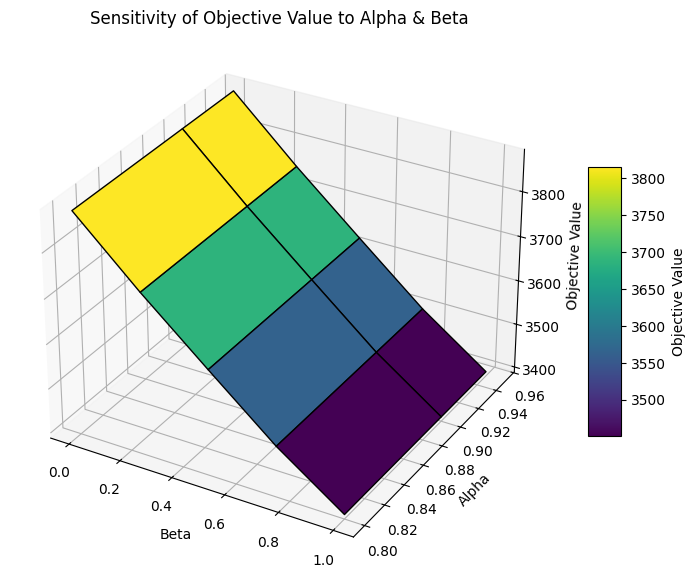

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Prepare grid
alphas = df_summary['alpha'].unique()
betas = df_summary['beta'].unique()
pivot = df_summary.pivot(index='alpha', columns='beta', values='objective')

X, Y = np.meshgrid(betas, alphas)
Z = pivot.values

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')

ax.set_xlabel('Beta')
ax.set_ylabel('Alpha')
ax.set_zlabel('Objective Value')
ax.set_title('Sensitivity of Objective Value to Alpha & Beta')
fig.colorbar(surf, shrink=0.5, aspect=8, label='Objective Value')

plt.show()


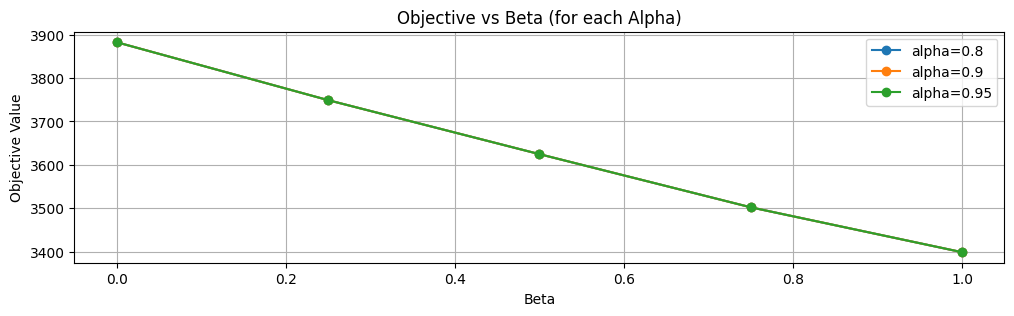

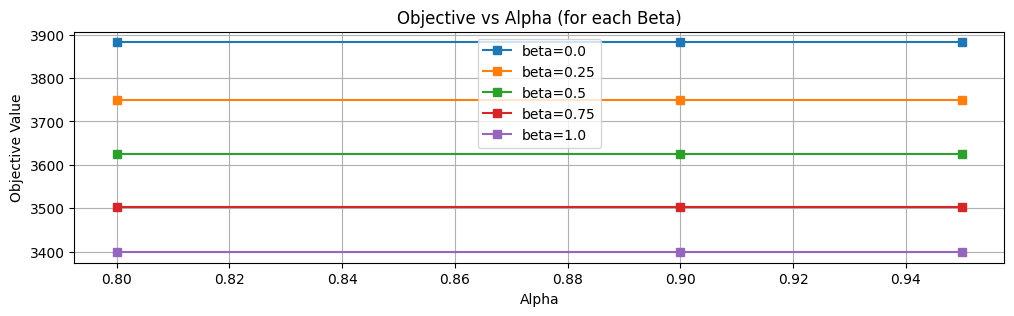

In [ ]:
# --- 2D Plot: Objective vs Beta for each Alpha ---
plt.figure(figsize=(12, 3))
for alpha in df_summary['alpha'].unique():
    subset = df_summary[df_summary['alpha'] == alpha]
    plt.plot(subset['beta'], subset['objective'], marker='o', label=f'alpha={alpha}')
plt.xlabel('Beta')
plt.ylabel('Objective Value')
plt.title('Objective vs Beta (for each Alpha)')
plt.legend()
plt.grid(True)
plt.show()


# --- 2D Plot: Objective vs Alpha for each Beta ---
plt.figure(figsize=(12, 3))
for beta in df_summary['beta'].unique():
    subset = df_summary[df_summary['beta'] == beta]
    plt.plot(subset['alpha'], subset['objective'], marker='s', label=f'beta={beta}')
plt.xlabel('Alpha')
plt.ylabel('Objective Value')
plt.title('Objective vs Alpha (for each Beta)')
plt.legend()
plt.grid(True)
plt.show()


    alpha  beta    objective  expected_profit  CVaR_profit       zeta
0    0.80  0.00  3882.598674      3882.598674       0.0000     0.0000
1    0.80  0.25  3749.103977      3875.101303    3371.1120  3371.1120
2    0.80  0.50  3624.555769      3872.646337    3376.4652  3376.4652
3    0.80  0.75  3501.971142      3860.928167    3382.3188  3382.3188
4    0.80  1.00  3398.420300      3398.420309    3398.4203  3398.4203
5    0.90  0.00  3882.598674      3882.598674       0.0000     0.0000
6    0.90  0.25  3749.103977      3875.101303    3371.1120  3371.1120
7    0.90  0.50  3624.555769      3872.646337    3376.4652  3376.4652
8    0.90  0.75  3501.971142      3860.928167    3382.3188  3382.3188
9    0.90  1.00  3398.420300      3398.420314    3398.4203  3398.4203
10   0.95  0.00  3882.598674      3882.598674       0.0000     0.0000
11   0.95  0.25  3749.103977      3875.101303    3371.1120  3371.1120
12   0.95  0.50  3624.555769      3872.646337    3376.4652  3376.4652
13   0.95  0.75  350

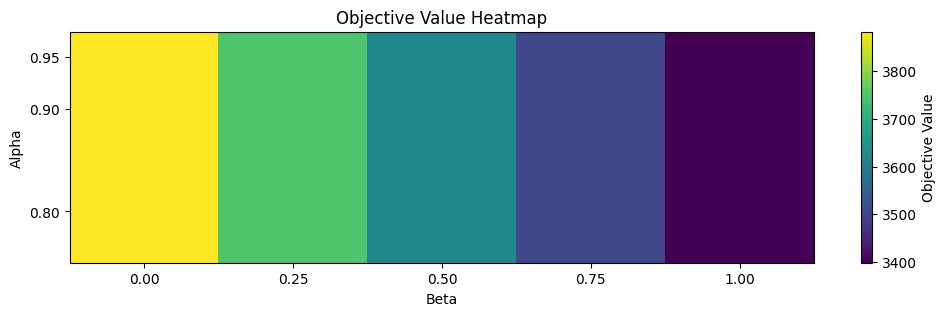

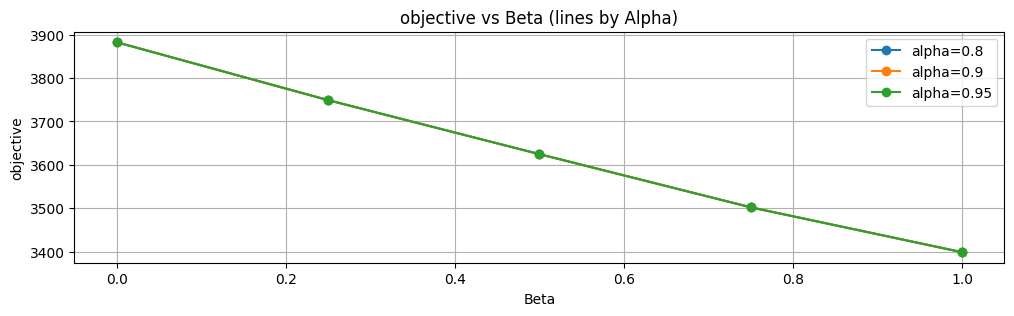

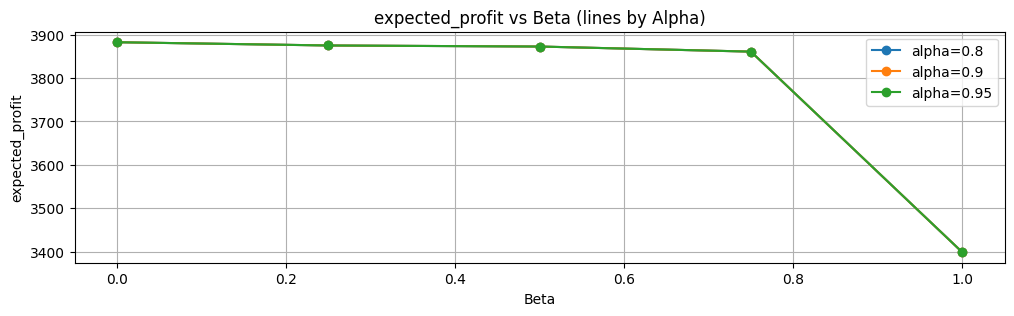

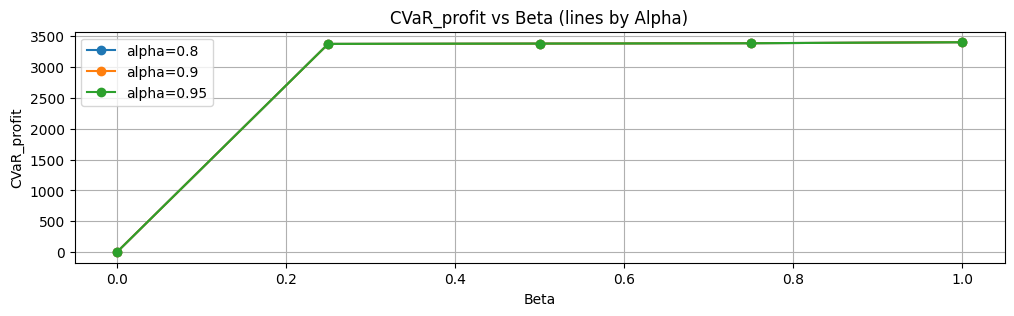

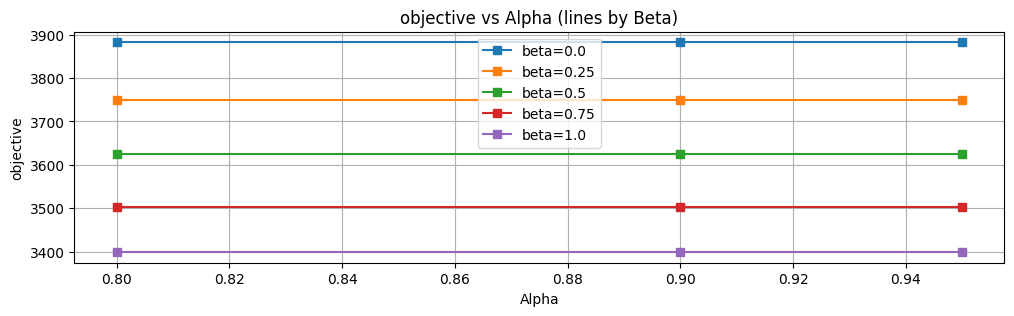

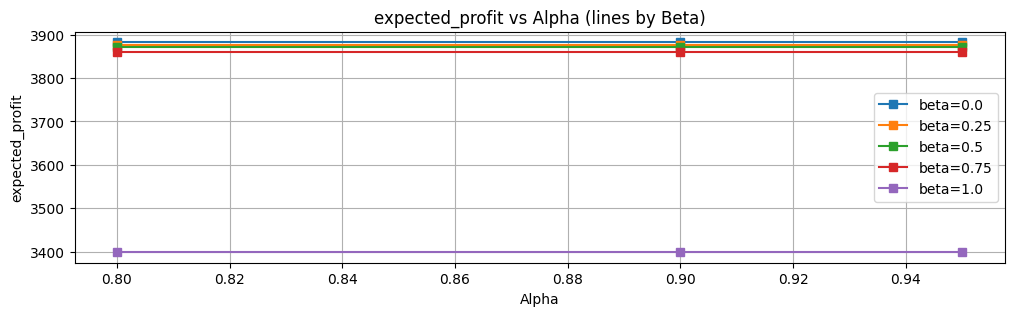

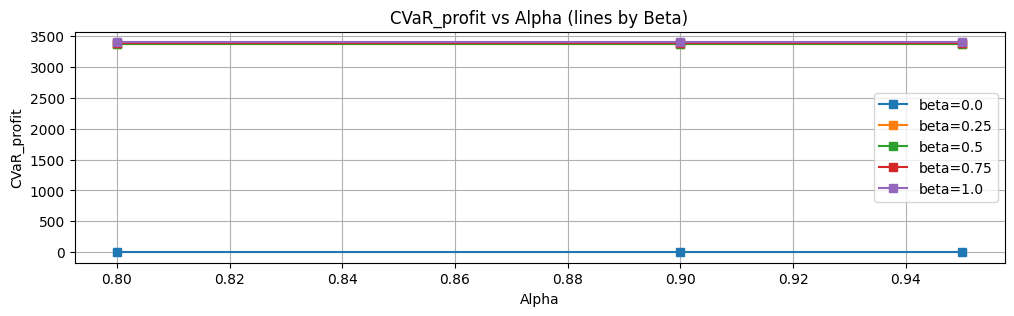

In [ ]:
import pyomo.environ as pe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyomo.opt import SolverFactory

# Define sensitivity ranges
alpha_values = [0.8, 0.9, 0.95]
beta_values = [0.0, 0.25, 0.5, 0.75, 1.0]

results_summary = []   # store results

# --- Sensitivity loop ---
for alpha in alpha_values:
    for beta in beta_values:

        # --- Model ---
        model = pe.ConcreteModel()

        # Sets
        model.T = pe.Set(initialize=T, ordered=True)
        model.Omega = pe.Set(initialize=Omega)

        # Variables: First-stage
        model.P_DA = pe.Var(model.T, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))
        model.b = pe.Var(model.T, domain=pe.Binary)

        # Two-stage battery variables
        model.P_ch_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_dis_DA = pe.Var(model.T, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_ch_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))
        model.P_dis_ID = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax))

        # Market variables
        model.P_ID = pe.Var(model.T, model.Omega, domain=pe.Reals, bounds=(-Pmax, Pmax_trade))
        model.delta_imb_plus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))
        model.delta_imb_minus = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Pmax_trade))

        # SOC
        model.SOC = pe.Var(model.T, model.Omega, domain=pe.NonNegativeReals, bounds=(0, Cap))

        # CVaR variables
        model.zeta = pe.Var(domain=pe.Reals)
        model.eta = pe.Var(model.Omega, domain=pe.NonNegativeReals)

        # Objective
        def expected_profit_rule(m):
            exp_profit = 0
            for omega in m.Omega:
                scenario_profit = 0
                for t in m.T:
                    scenario_profit += (
                        lambda_DA[t] * m.P_DA[t]
                        + lambda_ID[(t, omega)] * m.P_ID[t, omega]
                        - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
                    )
                exp_profit += pi_omega[omega] * scenario_profit
            cvar_term = m.zeta - (1 / (1 - alpha)) * sum(pi_omega[omega] * m.eta[omega] for omega in m.Omega)
            return (1 - beta) * exp_profit + beta * cvar_term
        model.obj = pe.Objective(rule=expected_profit_rule, sense=pe.maximize)

        # Constraints
        def power_balance_rule(m, t, omega):
            return (
                m.P_DA[t] + m.P_ID[t, omega] + m.delta_imb_minus[t, omega] - m.delta_imb_plus[t, omega]
                == PV[(t, omega)] + m.P_dis_DA[t] + m.P_dis_ID[t, omega] - (m.P_ch_DA[t] + m.P_ch_ID[t, omega])
            )
        model.power_balance = pe.Constraint(model.T, model.Omega, rule=power_balance_rule)

        def soc_balance_rule(m, t, omega):
            if t == m.T.first():
                return m.SOC[t, omega] == SOC0 + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - (
                    (m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis
                )
            else:
                return m.SOC[t, omega] == m.SOC[m.T.prev(t), omega] + eta_ch * (m.P_ch_DA[t] + m.P_ch_ID[t, omega]) - (
                    (m.P_dis_DA[t] + m.P_dis_ID[t, omega]) / eta_dis
                )
        model.soc_balance = pe.Constraint(model.T, model.Omega, rule=soc_balance_rule)

        def ch_limit_rule(m, t, omega):
            return m.P_ch_DA[t] + m.P_ch_ID[t, omega] <= Pmax * m.b[t]
        model.ch_limit = pe.Constraint(model.T, model.Omega, rule=ch_limit_rule)

        def dis_limit_rule(m, t, omega):
            return m.P_dis_DA[t] + m.P_dis_ID[t, omega] <= Pmax * (1 - m.b[t])
        model.dis_limit = pe.Constraint(model.T, model.Omega, rule=dis_limit_rule)

        def shortfall_rule(m, omega):
            profit_omega = sum(
                lambda_DA[t] * m.P_DA[t]
                + lambda_ID[(t, omega)] * m.P_ID[t, omega]
                - c_imb * (m.delta_imb_plus[t, omega] + m.delta_imb_minus[t, omega])
                for t in m.T
            )
            return m.eta[omega] >= m.zeta - profit_omega
        model.shortfall = pe.Constraint(model.Omega, rule=shortfall_rule)

        # --- Solve ---
        solver = SolverFactory('cbc')
        solver.solve(model, tee=False)

        # --- Compute expected profit & CVaR ---
        scenario_profits = {}
        for omega in model.Omega:
            profit_omega = sum(
                lambda_DA[t] * pe.value(model.P_DA[t])
                + lambda_ID[(t, omega)] * pe.value(model.P_ID[t, omega])
                - c_imb * (pe.value(model.delta_imb_plus[t, omega]) + pe.value(model.delta_imb_minus[t, omega]))
                for t in model.T
            )
            scenario_profits[omega] = profit_omega

        expected_profit = sum(pi_omega[omega] * scenario_profits[omega] for omega in model.Omega)

        zeta_val = pe.value(model.zeta)
        eta_vals = {omega: pe.value(model.eta[omega]) for omega in model.Omega}
        cvar_value = zeta_val - (1.0 / (1.0 - alpha)) * sum(pi_omega[omega] * eta_vals[omega] for omega in model.Omega)

        # --- Save results ---
        results_summary.append({
            'alpha': alpha,
            'beta': beta,
            'objective': pe.value(model.obj),
            'expected_profit': expected_profit,
            'CVaR_profit': cvar_value,
            'zeta': zeta_val
        })


# --- Results DataFrame ---
df_summary = pd.DataFrame(results_summary)
print(df_summary)

# --- Heatmap of objective ---
pivot = df_summary.pivot(index='alpha', columns='beta', values='objective')
plt.figure(figsize=(12, 3))
c = plt.pcolor(pivot.columns, pivot.index, pivot.values, shading='auto')
plt.colorbar(c, label="Objective Value")
plt.xlabel("Beta")
plt.ylabel("Alpha")
plt.title("Objective Value Heatmap")
plt.xticks(pivot.columns)
plt.yticks(pivot.index)
plt.show()

# --- 2D plots vs Beta (lines for each alpha) ---
for metric in ['objective', 'expected_profit', 'CVaR_profit']:
    plt.figure(figsize=(12, 3))
    for alpha in sorted(df_summary['alpha'].unique()):
        subset = df_summary[df_summary['alpha'] == alpha].sort_values('beta')
        plt.plot(subset['beta'], subset[metric], marker='o', label=f'alpha={alpha}')
    plt.xlabel('Beta')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Beta (lines by Alpha)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 2D plots vs Alpha (lines for each beta) ---
for metric in ['objective', 'expected_profit', 'CVaR_profit']:
    plt.figure(figsize=(12, 3))
    for beta in sorted(df_summary['beta'].unique()):
        subset = df_summary[df_summary['beta'] == beta].sort_values('alpha')
        plt.plot(subset['alpha'], subset[metric], marker='s', label=f'beta={beta}')
    plt.xlabel('Alpha')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Alpha (lines by Beta)')
    plt.legend()
    plt.grid(True)
    plt.show()
